**Brian Blaylock**  
*December 22, 2020*

# ⚡ GLM Geostationary field-of-view in Cartopy
Based on information from [glmtools](https://github.com/deeplycloudy/glmtools/blob/master/examples/FixedGridDomains.ipynb)

- [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf)
    - Lens field of view = +/- 8 degrees (16-degree field of view) (pg 57, 225).
    - Ground sample distance = 8 - 14 km (pg 225).
    - Background Image from GLM (Fig. 4-12, pg 69).
    - Focal Plane is subdivided into 56 physical regions or *subarrays*, 49 pixels tall by 650 pixels wide (Fig. 4-13, pg 70).
    - GLM field-of-view shown in Fig 4-3 (pg 59).

From glmtools
> The GLM full-disk (minimum spec) is defined as the intersection of circular and square Earth-centered fields-of-view having minimum diameter 15.59° and minimum length 14.81° respectively. It seems that 16 and 15 deg, respectively, better matches Fig. 4-3 in the GOES data book.



In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

from goes2go.data import goes_latest, goes_nearesttime
from goes2go.tools import field_of_view

from BB_maps.add_to_cartopy import common_features, pc

In [2]:
g16 = goes_latest(satellite='G16', product='GLM')
g17 = goes_latest(satellite='G17', product='GLM')

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: GLM-L2-LCFA      |
📦 Finished downloading [1] files to [/p/home/blaylock/data/noaa-goes16/GLM-L2-LCFA].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Get the data's coordinate reference system and field of view with the `goes2go.tools.field_of_view` function
This returns both the field of view as a shapely polygon and the cartopy coordinate reference system.

In [3]:
FOV_16, geo16 = field_of_view(g16)
FOV_17, geo17 = field_of_view(g17)

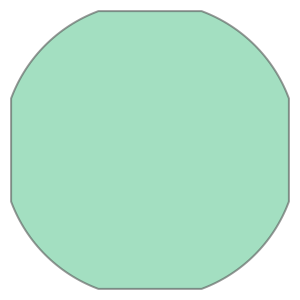

In [4]:
FOV_16  # This is the polygon

In [5]:
geo16  # This is the cartopy crs

/p/home/blaylock/anaconda3/envs/basic/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:154: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


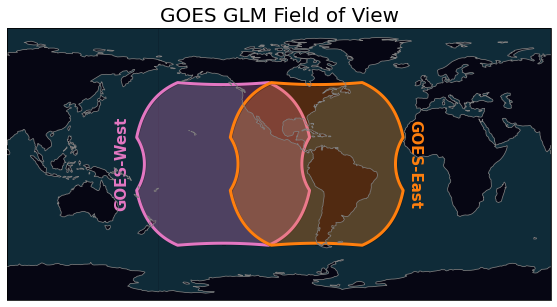

In [6]:
ax = common_features(OCEAN=True, LAND=True, projection=ccrs.PlateCarree(central_longitude=-100), figsize=[10,5], dark_theme=True)

# I have to use the buffer to reduce the geo boundary because cartopy doesn't
# draw an exact boundary. For this visualization purpose, this is OK.

# Draw boundary of GOES17
ax.add_geometries([FOV_17], crs=geo17,
                   facecolor='tab:pink', edgecolor='k', alpha=0.3, linewidth=3)
ax.add_geometries([FOV_17], crs=geo17,
                   facecolor='none', edgecolor='tab:pink', alpha=1, linewidth=3)

# Draw boundary of GOES16
ax.add_geometries([FOV_16], crs=geo16,
                   facecolor='tab:orange', edgecolor='k', alpha=0.3, linewidth=3)
ax.add_geometries([FOV_16], crs=geo16,
                   facecolor='none', edgecolor='tab:orange', alpha=1, linewidth=3)


ax.text(g17.lon_field_of_view-72,
        g17.lat_field_of_view,
        'GOES-West', transform=pc,
       rotation=90, va='center', fontsize=15, color='tab:pink', fontweight='bold')

ax.text(g16.lon_field_of_view+60,
        g16.lat_field_of_view,
        'GOES-East', transform=pc,
       rotation=-90, va='center', fontsize=15, color='tab:orange', fontweight='bold')

plt.title('GOES GLM Field of View', fontsize=20)

plt.savefig('../images/GLM_field-of-view.png')

You will notice that the GLM field of view is smaller than the ABI field of view

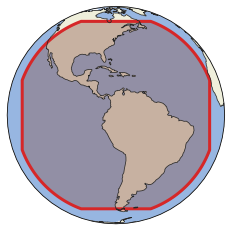

In [7]:
ax = common_features(projection=geo16, LAND=True, OCEAN=True)
ax.add_geometries([FOV_16], crs=geo16, alpha=.4, color='tab:brown')
ax.add_geometries([FOV_16], crs=geo16, edgecolor='tab:red', lw=3,  facecolor='none')

What is the overlap from GOES West, as viewed from GOES East?

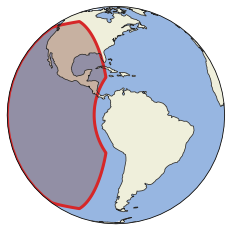

In [8]:
ax = common_features(projection=geo16, LAND=True, OCEAN=True)
ax.add_geometries([FOV_17], crs=geo17, alpha=.4, color='tab:brown')
ax.add_geometries([FOV_17], crs=geo17, edgecolor='tab:red', lw=3,  facecolor='none')

---

# A note about GLM's field of view
The GLM's documented field of view is +/- 8 degrees from its view at nadir. However, in all the official papers, the GLM field of view is shown to have a boundary that is not circular. 

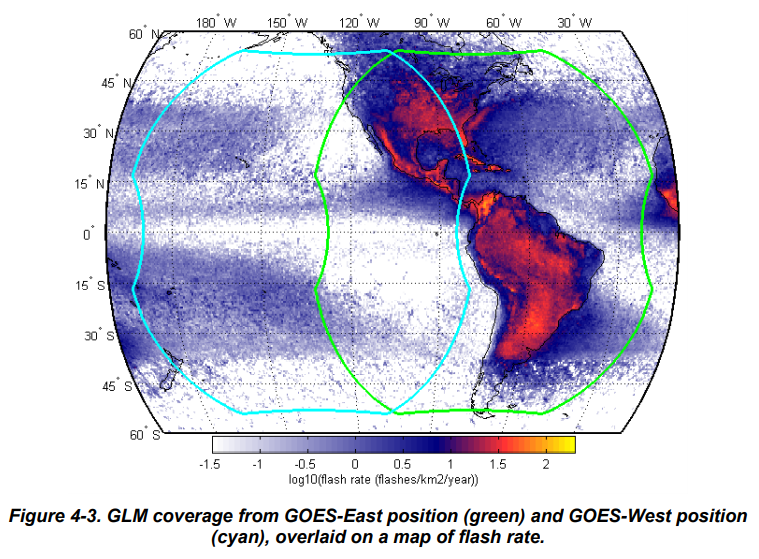

There is a limitation on the top, bottom, left, and right sides of that view. The only place I have found this mentioned is in this [glmtools notebook](https://github.com/deeplycloudy/glmtools/blob/master/examples/FixedGridDomains.ipynb). It claims there is a square boundary with radius smaller than the 16 degree field of view. I used the same general method to trim off these boundaries.

In [22]:
from shapely.geometry import Point, Polygon

sat_h = 35786023.4375
nadir_lon = -75
nadir_lat = 0

resolution = 60

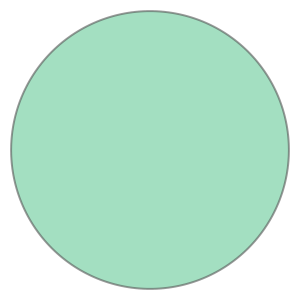

In [18]:
# create the circular field of view
FOV_radius_circle = np.radians(16/2) * sat_h
FOV_circle = Point(nadir_lon, nadir_lat).buffer(FOV_radius_circle,
                                                resolution=resolution)
FOV_circle

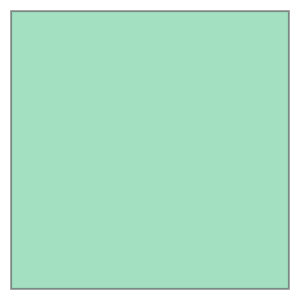

In [23]:
# create the square field of view
# this is more than just the corner points
FOV_radius_square = np.radians(15/2) * sat_h
# Create a square with many points clockwise, starting in bottom left corner
side1x, side1y = np.ones(resolution)*-FOV_radius_square, np.linspace(-FOV_radius_square, FOV_radius_square, resolution), 
side2x, side2y = np.linspace(-FOV_radius_square, FOV_radius_square, resolution), np.ones(resolution)*FOV_radius_square
side3x, side3y = np.ones(resolution)*FOV_radius_square, np.linspace(FOV_radius_square, -FOV_radius_square, resolution),
side4x, side4y = np.linspace(FOV_radius_square, -FOV_radius_square, resolution), np.ones(resolution)*-FOV_radius_square
x = np.hstack([side1x, side2x, side3x, side4x])
y = np.hstack([side1y, side2y, side3y, side4y])
FOV_square = Polygon(zip(x,y))
FOV_square

Now take the intersection of the two shapes, and that is the GLM field of view

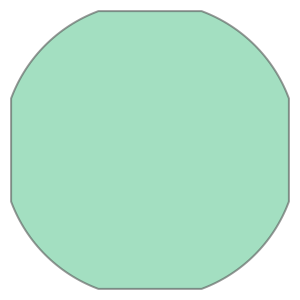

In [26]:
final_FOV = FOV_circle.intersection(FOV_square)
final_FOV

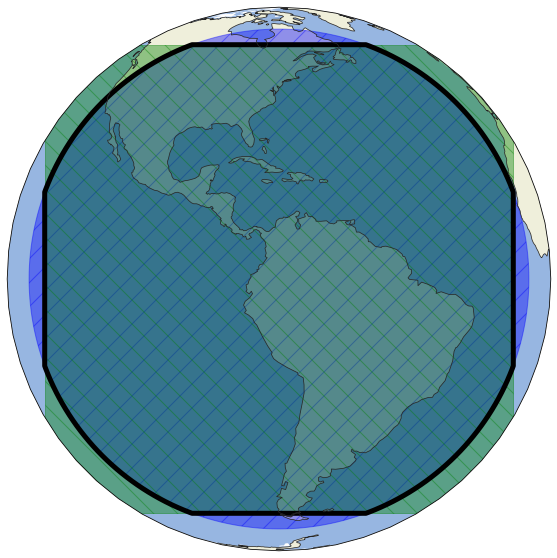

In [60]:
# Plotted on a cartopy map
ax = common_features(projection=geo16, LAND=True, OCEAN=True, figsize=[10,10])
ax.add_geometries([FOV_circle], crs=geo16, alpha=.4, color='blue', hatch='/')
ax.add_geometries([FOV_square], crs=geo16, alpha=.4, color='green', hatch='\\')

ax.add_geometries([final_FOV], crs=geo16,
                  facecolor='none', edgecolor='k', linewidth=5)